In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def prepare_model(data, features, max_depth):
    
    X_train, X_test, y_train, y_test = train_test_split(data[features['molecular descriptor name']], 
                                                        data['Aktywność cytoprotekcyjna [%]'], 
                                                        test_size=0.07, random_state=42)
    
    dtr = DecisionTreeRegressor(random_state=15, max_depth=max_depth)
    
    dtr.fit(X_train, y_train)
    print("Return the coefficient of determination of the prediction: ")
    print(dtr.score(X_test, y_test))

    pred = dtr.predict(X_train)
    print("R^2 score: "+ str(r2_score(y_train, pred)))
    sqrt_r2 = np.sqrt(r2_score(y_train, pred))
    training_data_r2 = r2_score(y_train, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = dtr.predict(X_test)
    print("R^2 score: "+ str(r2_score(pred, y_test)))
    sqrt_r2 = np.sqrt(r2_score(pred, y_test))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(y_test) 
    test_data_r2 = r2_score(pred, y_test)
    
    return dtr, training_data_r2, test_data_r2
    

In [6]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [7]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization, max_depth):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        #test_ = test_data(stand)
        
        #data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, max_depth)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        #test_ = test_data(data_to_be_prepared)
        
        #data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, max_depth)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [8]:
molecular_descriptors_df = prepare_data('../Data/Indole_-_cytoprotekcja_.xlsx')

 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:01<00:00, 32.09it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 23.08it/s]


(44, 1613)
(44, 1433)
(44, 1182)


In [9]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False, 5)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520        

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


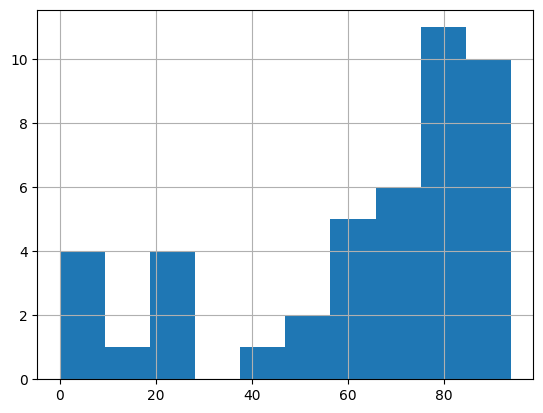

In [10]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [11]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 12


In [12]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
456,BCUTare-1l,0.345707,0.345707
520,ETA_dEpsilon_D,0.412783,0.412783
829,NaaNH,0.386873,0.386873
831,NaaS,-0.343855,0.343855
899,SaaNH,0.359872,0.359872
901,SaaS,-0.343855,0.343855
913,SlogP_VSA1,0.338615,0.338615
1030,VR1_A,-0.339451,0.339451
1040,VR2_A,-0.339146,0.339146
1126,n6HRing,0.362058,0.362058


In [13]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.33, True, 5)

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [14]:
with_standarization.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [15]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([81.11111111, 84.        , 71.        , 68.21428571, 68.21428571,
       68.21428571, 68.21428571, 68.21428571, 47.75      , 47.75      ,
        0.        , 68.21428571, 47.75      ,  0.        , 28.        ,
       55.        , 81.        , 81.11111111, 81.11111111, 81.11111111,
       81.11111111, 71.        , 17.        , 62.        , 87.5       ,
       81.11111111, 81.11111111, 47.75      , 64.        , 81.11111111,
       81.11111111, 87.5       , 28.        , 68.21428571, 24.        ,
        0.        , 87.5       , 87.5       , 87.5       , 87.5       ,
       87.5       , 87.5       , 87.5       , 81.11111111])

In [16]:
len(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]))

44

In [17]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [18]:
xs

0.6956455294116886

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


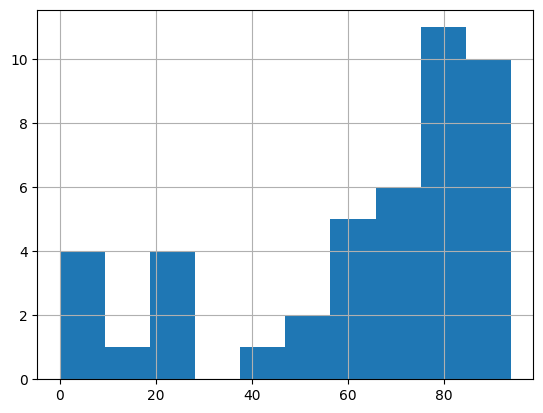

In [19]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [20]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 12


In [21]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
456,BCUTare-1l,0.345707,0.345707
520,ETA_dEpsilon_D,0.412783,0.412783
829,NaaNH,0.386873,0.386873
831,NaaS,-0.343855,0.343855
899,SaaNH,0.359872,0.359872
901,SaaS,-0.343855,0.343855
913,SlogP_VSA1,0.338615,0.338615
1030,VR1_A,-0.339451,0.339451
1040,VR2_A,-0.339146,0.339146
1126,n6HRing,0.362058,0.362058


## Search inside correlation space

In [22]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
max_depth = [range(2, 30, 1)]
corr_th = []
second_list = []
third_list = []
f_list = []
fif_list = []
for i in first_list:
    for depth in max_depth[0]:
        
        without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False, depth)
        corr_th.append(i)
        second_list.append(train_r2)
        third_list.append(test_r2)
        f_list.append(len(h_))
        fif_list.append(depth)


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53         

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.15266149870801038
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.8574887582151502
Correlation coefficient: nan
[90. 62. 76. 55.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.2709043927648578
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.029317565902932
Correlation coefficient: nan
[93. 55. 76. 55.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    A

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
455                BCUTare-1h    0.323770                    0.323770
45

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.35923100775193806
R^2 score: 0.9926460652561423
Correlation coefficient: 0.996316247612244
Test data - unseen during training:
R^2 score: -3.6066023988342115
Correlation coefficient: nan
[93.  62.  82.2 62. ]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
455                BCUTare-1h    0.323770                    0.323770
45

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.15266149870801038
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.8574887582151502
Correlation coefficient: nan
[90. 62. 76. 55.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.15266149870801038
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.8574887582151502
Correlation coefficient: nan
[90. 62. 76. 55.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
455                BCUTare-1h    0.323770                    0.323770
45

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.23723834539902233
R^2 score: 0.5765064175841811
Correlation coefficient: 0.7592801970183215
Test data - unseen during training:
R^2 score: 0.0
Correlation coefficient: 0.0
[79.22727273 79.22727273 79.22727273 79.22727273]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
461                 BCUTdv-1h    0.298210                    0.298210
Return the coefficient of determination of the prediction: 
-0.10346253229974156
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -3.9517625231910944
Correlation coefficient: nan
[90. 62. 76. 62.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.10346253229974156
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -3.9517625231910944
Correlation coefficient: nan
[90. 62. 76. 62.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
469                 BCUTpe-1h    0.317690                    0.317690
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
469                 BCUTpe-1h    0.317690                    0.317690
Return the coefficient of determination of the prediction: 
0.7531782945736434
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

Return the coefficient of determination of the prediction: 
0.2802067183462532
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.4343729694606887
Correlation coefficient: 0.6590697758664774
[91. 46. 28. 91.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2       

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

Return the coefficient of determination of the prediction: 
0.2802067183462532
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.4343729694606887
Correlation coefficient: 0.6590697758664774
[91. 46. 28. 91.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2       

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

Return the coefficient of determination of the prediction: 
-0.3752002583979328
R^2 score: 0.6221305795591198
Correlation coefficient: 0.7887525464675976
Test data - unseen during training:
R^2 score: 0.0
Correlation coefficient: 0.0
[82.3125 82.3125 82.3125 82.3125]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.1200000000000001
R^2 score: 0.9998593395876423
Correlation coefficient: 0.9999296673204783
Test data - unseen during training:
R^2 score: -16.254777070063696
Correlation coefficient: nan
[93. 82. 76. 87.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.1200000000000001
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -16.254777070063696
Correlation coefficient: nan
[93. 82. 76. 87.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
-0.1200000000000001
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -16.254777070063696
Correlation coefficient: nan
[93. 82. 76. 87.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

0.9756072351421189
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.9773251345119139
Correlation coefficient: 0.9885975594304863
[93. 87. 28. 64.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044


C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

Return the coefficient of determination of the prediction: 
0.4468217054263566
R^2 score: 0.982724817504511
Correlation coefficient: 0.9913247790227535
Test data - unseen during training:
R^2 score: -1.715372907153729
Correlation coefficient: nan
[93. 84. 64. 72.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.1

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
0.4468217054263566
R^2 score: 0.982724817504511
Correlation coefficient: 0.9913247790227535
Test data - unseen during training:
R^2 score: -1.715372907153729
Correlation coefficient: nan
[93. 84. 64. 72.]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.1

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829      

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Correlation coefficient: nan
[93.  85.5 86.  92. ]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


R^2 score: -86.04194857916103
Correlation coefficient: nan
[93.  85.5 86.  92. ]
37    94.0
24    80.0
25    28.0
36    67.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698   

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1785933408.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [23]:
df_without_standarization = pd.DataFrame(data=corr_th, columns=["Correlation threshold"])

In [24]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list
df_without_standarization['Depth number'] = fif_list

In [25]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
0,0.25,0.576506,0.000000,46,2
1,0.25,0.760847,-5.803401,46,3
2,0.25,0.939324,-3.081030,46,4
3,0.25,0.981105,-2.831780,46,5
4,0.25,0.992646,-2.731484,46,6
...,...,...,...,...,...
415,0.39,0.932661,-86.041949,2,25
416,0.39,0.932661,-86.041949,2,26
417,0.39,0.932661,-86.041949,2,27
418,0.39,0.932661,-86.041949,2,28


## Plots

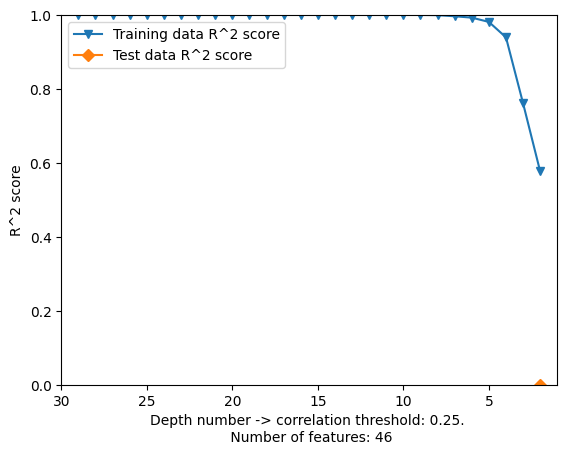

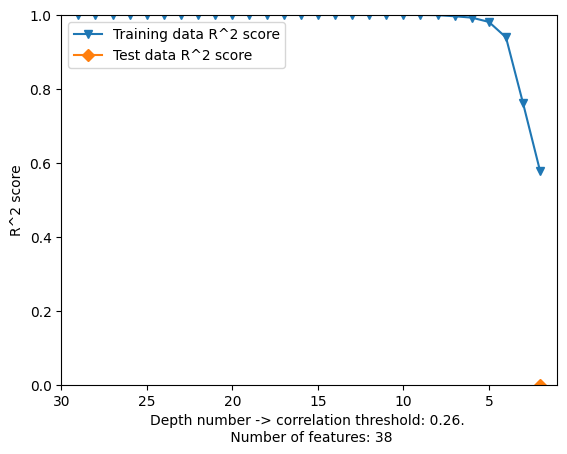

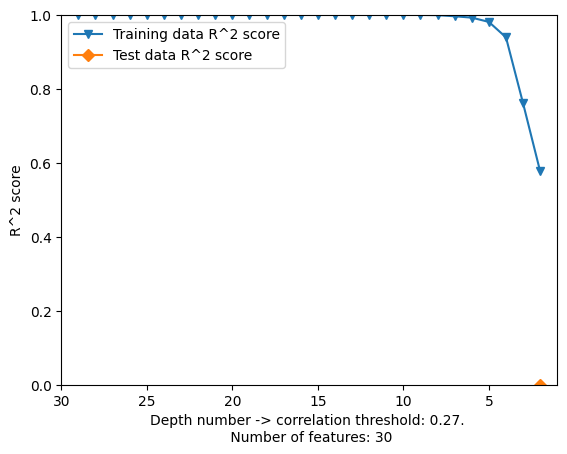

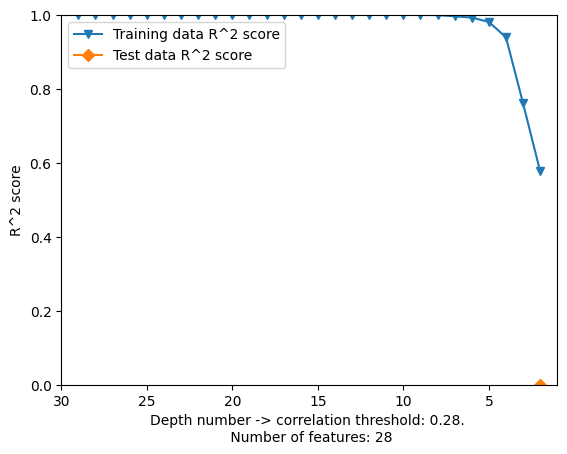

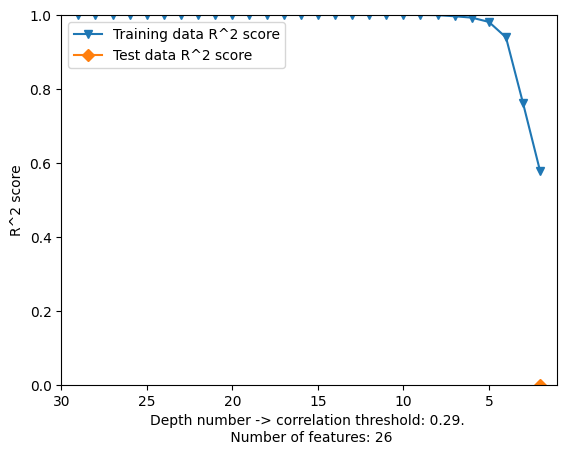

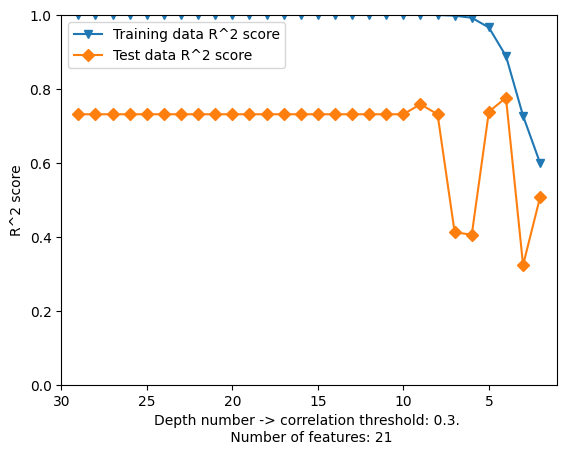

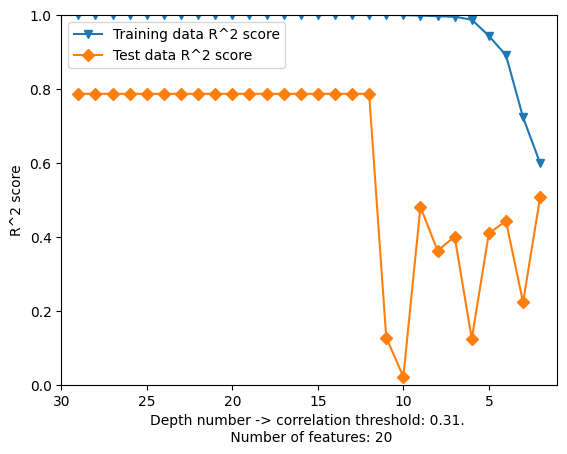

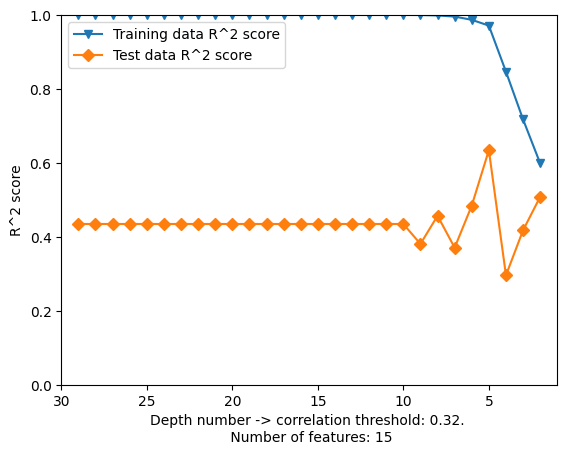

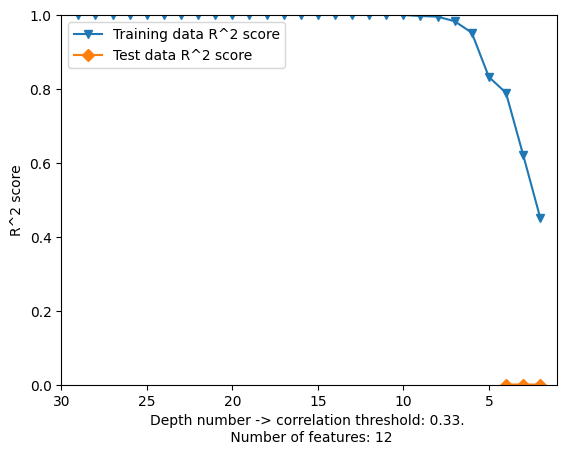

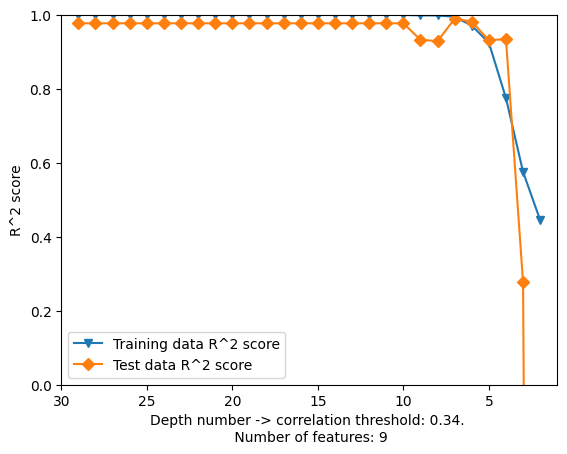

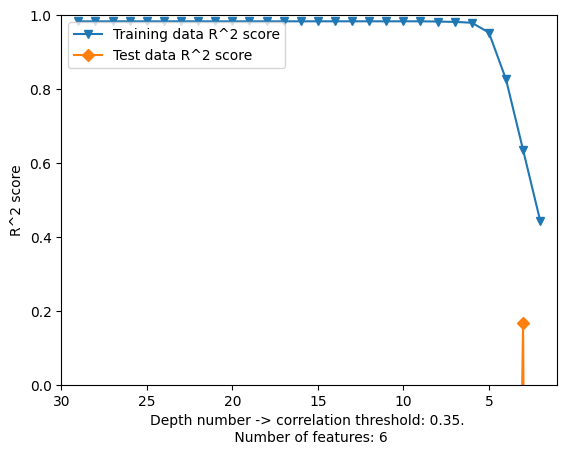

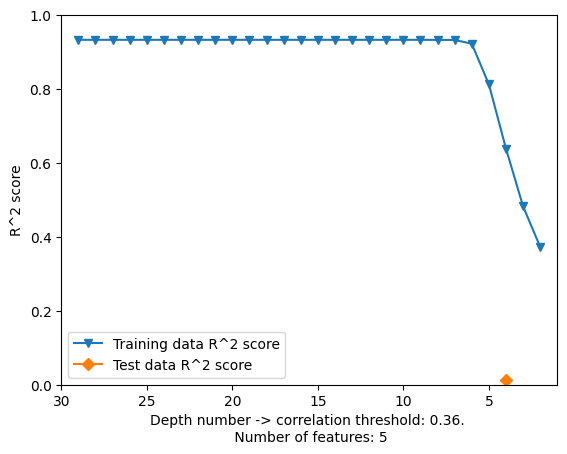

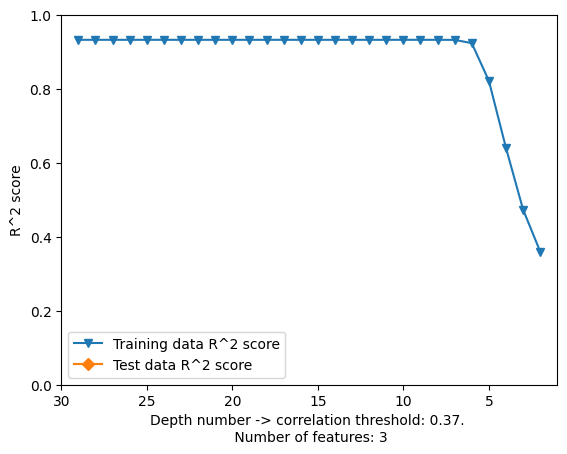

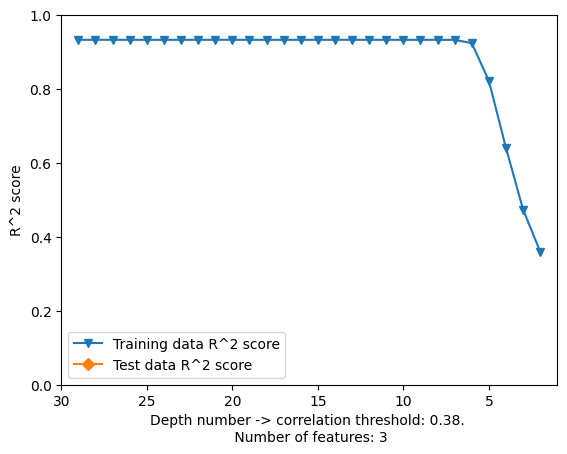

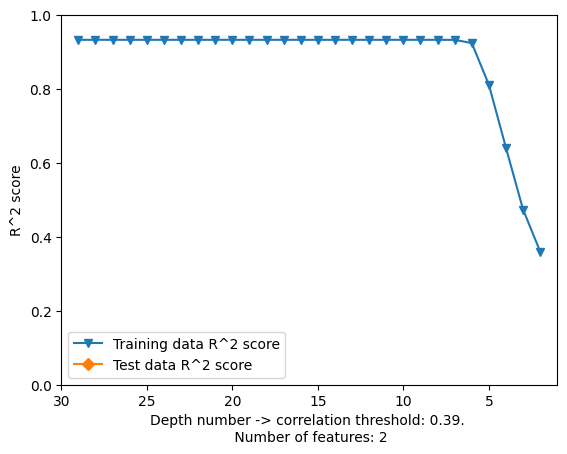

In [26]:
corre_list = [x / 100.0 for x in range(int(0.25*100), int(0.40*100), int(0.01*100))]
for element in corre_list:
    element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == float(element)]
    plt.plot(element_['Depth number'], element_['Training data R^2 score'], label = "Training data R^2 score", marker='v')
    plt.plot(element_['Depth number'], element_['Test data R^2 score'], label = "Test data R^2 score", marker='D')
    plt.legend()
    plt.xlabel('Depth number -> correlation threshold: '+str(element)+'. \n Number of features: '+str(element_['Number of features'].iloc[0]))
    plt.xlim(max(element_['Depth number'])+1, min(element_['Depth number'])-1)
    plt.ylabel('R^2 score')
    plt.ylim([0, 1])
    plt.show()

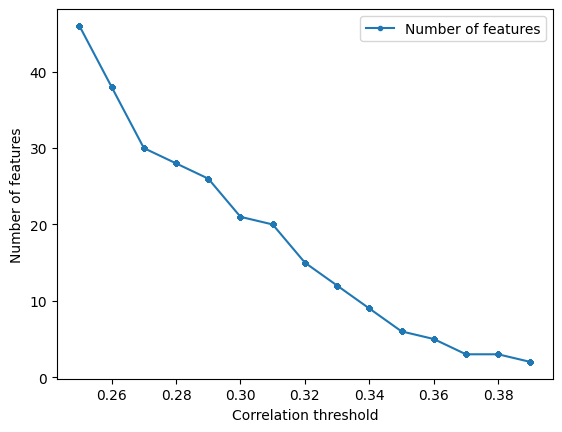

In [27]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

In [28]:
element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.34]
element_

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
252,0.34,0.444721,-6.872827,9,2
253,0.34,0.575288,0.276157,9,3
254,0.34,0.775051,0.934825,9,4
255,0.34,0.924825,0.931263,9,5
256,0.34,0.971009,0.982065,9,6
257,0.34,0.994946,0.989578,9,7
258,0.34,0.998494,0.929061,9,8
259,0.34,0.998871,0.932789,9,9
260,0.34,1.000000,0.977325,9,10
261,0.34,1.000000,0.977325,9,11


# sqrt(R^2)

In [29]:
r_a = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.34]

In [30]:
r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1725905962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]


In [31]:
xcz = []
for element in r_a['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\1103940851.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [32]:
xcz

[0,
 0.5255063798805288,
 0.9668632361351898,
 0.9650199119251006,
 0.9909916895244387,
 0.9947754088433645,
 0.9638781859379302,
 0.9658098733571698,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863,
 0.9885975594304863]

In [33]:
r_a['test R value'] = xcz

C:\Users\aleks\AppData\Local\Temp\ipykernel_4832\2716572536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_a['test R value'] = xcz


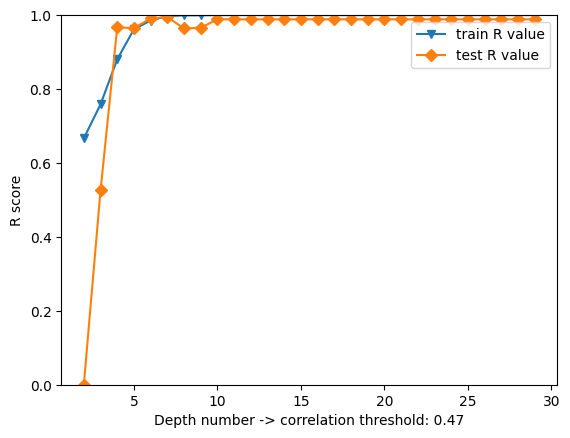

In [34]:
plt.plot(r_a['Depth number'], r_a['train R value'], label = "train R value", marker='v')
plt.plot(r_a['Depth number'], r_a['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Depth number -> correlation threshold: 0.47')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

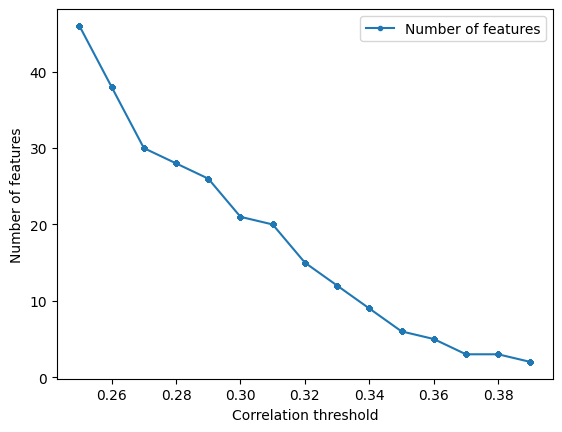

In [35]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [36]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.34, False, 5)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520        

In [37]:
final_model[0].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [38]:
final_model[0]

DecisionTreeRegressor(max_depth=5, random_state=15)

In [39]:
final_model[0].tree_

In [40]:
final_model[4]['molecular descriptor name'].to_list()

['BCUTare-1l',
 'ETA_dEpsilon_D',
 'NaaNH',
 'NaaS',
 'SaaNH',
 'SaaS',
 'n6HRing',
 'n6aHRing',
 'nHBDon']

In [41]:
from sklearn import tree

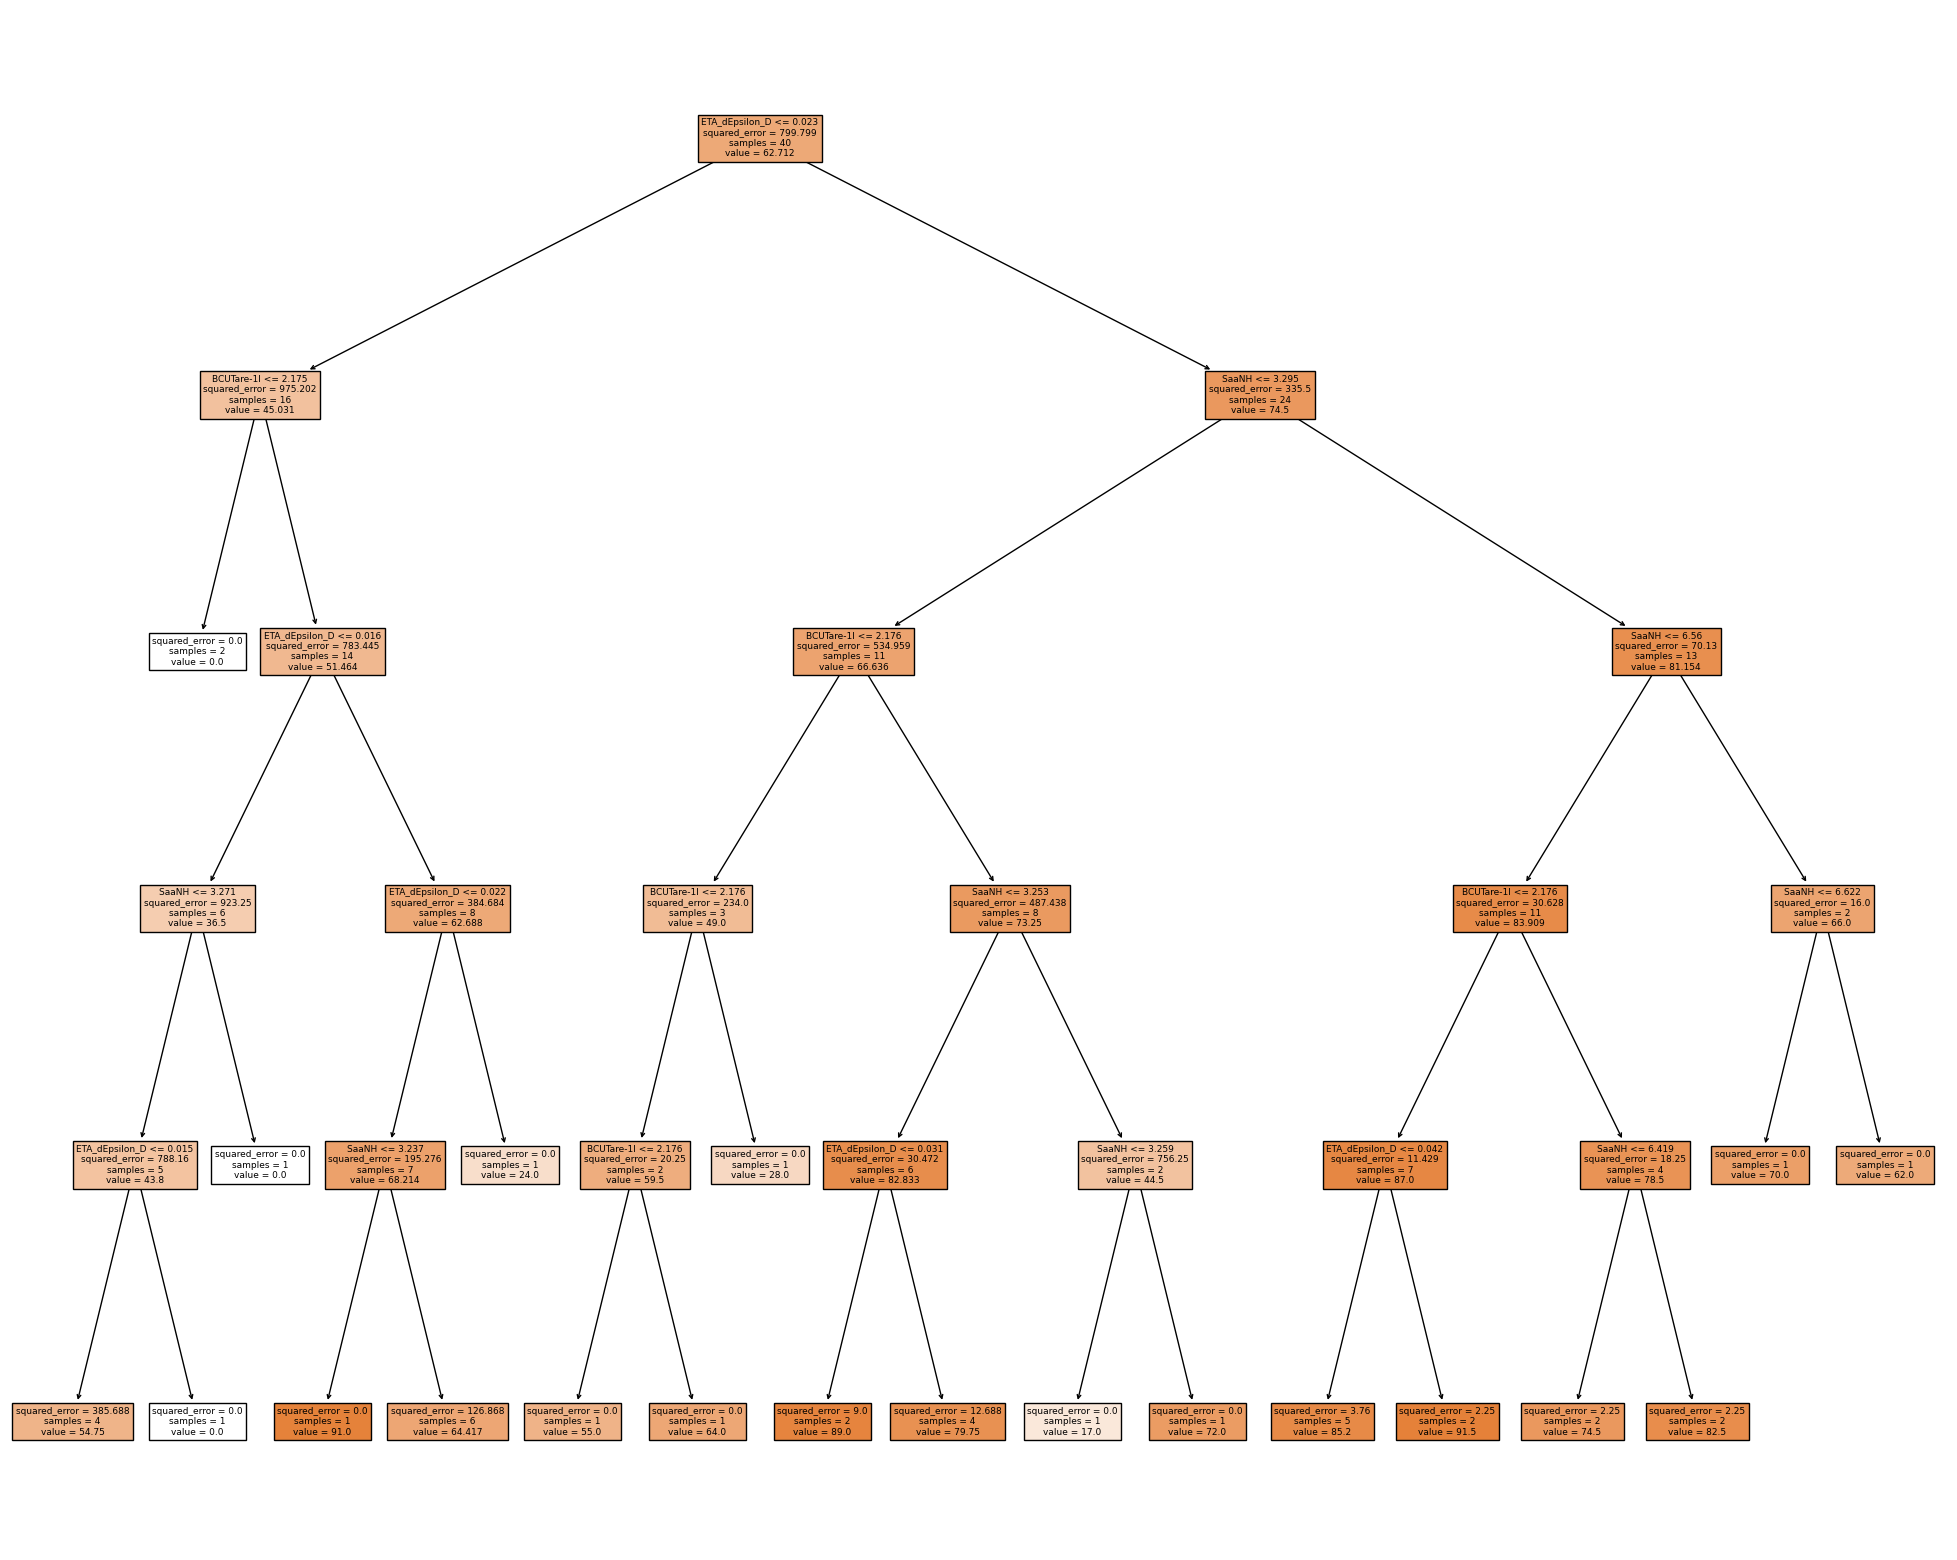

In [42]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_model[0], 
                   feature_names = final_model[4]['molecular descriptor name'].to_list(),
                   filled=True)

## Predict target feature

In [44]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')

 21%|████████████████▌                                                               | 184/891 [00:03<00:10, 69.61it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 23%|██████████████████▏                                                             | 203/891 [00:03<00:08, 83.81it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 872/891 [00:10<00:00, 73.55it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 84.08it/s]


(891, 1613)
(891, 1226)
(891, 1100)


In [45]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [47]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [48]:
print(len(smiles))
print(len(predicted_activity))

891
891


In [49]:
save_to_df.head()

,SMILES
0,C1=CN(Cc2c[nH]c3ccccc23)CN1
1,C=C1NCc2cn(c(CC)n2)CC2(C)C=CC=C12
2,C=C1C=C(C)NCC2C=CC2CN1
3,C=C1CN(Cc2c[nH]c3ccccc23)C=N1
4,Cc1ncc2n1CC1=CC=CC1CNC2


In [50]:
save_to_df['Predicted activity'] = predicted_activity

In [51]:
save_to_df.head()

,SMILES,Predicted activity
0,C1=CN(Cc2c[nH]c3ccccc23)CN1,72.00
1,C=C1NCc2cn(c(CC)n2)CC2(C)C=CC=C12,89.00
2,C=C1C=C(C)NCC2C=CC2CN1,79.75
3,C=C1CN(Cc2c[nH]c3ccccc23)C=N1,72.00
4,Cc1ncc2n1CC1=CC=CC1CNC2,89.00


In [52]:
save_to_df.to_excel('../Data/Predicted_activity_decision_tree.xlsx')